In [2]:
import numpy as np
import cv2

In [2]:
# Configuration and pretrained weights required for YOLO
cfgFile = "yolov4_train.cfg"
weightsFile = "yolov4_train_final.weights"
classNames = "classes.name"

In [3]:
#Load Yolo object detector
net = cv2.dnn.readNet(weightsFile,cfgFile)
classes = []
with open(classNames, "r") as f:
    classes = [line.strip() for line in f.readlines()]

In [4]:
video = cv2.VideoCapture("sports.mp4")

In [5]:
# Capture the first frame and obtain the properties required for video writing
ok, frame = video.read()

# Exit if video not opened
if not video.isOpened():
    print("Could not open video")
    sys.exit()
else:
    # Get video properties
    frame_width = int(video.get(3))
    frame_height = int(video.get(4))
    fps = int(video.get(5))

# Create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*"XVID")
video_out = cv2.VideoWriter("sportsyolo_custom.mp4", fourcc, fps, (frame_width, frame_height))

In [6]:
# Initialize an empty list to store centroids
centroids1 = []
centroids2 = []

In [13]:
while True:
    ret, frame = video.read()
    if not ret:
        break

    # Forward pass to get bounding boxes
    blob = cv2.dnn.blobFromImage(frame, 1/255, (608, 608), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(net.getUnconnectedOutLayersNames())

    # Post-process the output
    class_ids1 = []
    confidences1 = []
    class_ids2 = []
    confidences2 = []
    boxes1 = []
    boxes2 = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5 and class_id == 0:  # Assuming class_id 0 is for boxing
                center_x = int(detection[0] * frame.shape[1])
                center_y = int(detection[1] * frame.shape[0])
                w = int(detection[2] * frame.shape[1])
                h = int(detection[3] * frame.shape[0])

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                
                boxes1.append([x, y, w, h])
                confidences1.append(float(confidence))
                class_ids1.append(class_id)
            if confidence > 0.5 and class_id == 1:  # Assuming class_id 0 is for boxing
                center_x = int(detection[0] * frame.shape[1])
                center_y = int(detection[1] * frame.shape[0])
                w = int(detection[2] * frame.shape[1])
                h = int(detection[3] * frame.shape[0])

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes2.append([x, y, w, h])
                confidences2.append(float(confidence))
                class_ids2.append(class_id)

    # Non-maximum suppression to remove redundant boxes
    indices1 = cv2.dnn.NMSBoxes(boxes1, confidences1, 0.5, 0.4)
    indices2 = cv2.dnn.NMSBoxes(boxes2, confidences2, 0.5, 0.4)

    # Draw bounding boxes and compute centroids
    for i in indices1:
        #i = i[0]
        box = boxes1[i]
        x, y, w, h = box
        centroid_x = x + w // 2
        centroid_y = y + h // 2

        # Draw bounding box
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Draw centroid
        cv2.circle(frame, (centroid_x, centroid_y), 5, (0, 0, 255), -1)

        # Store centroid
        centroids1.append((centroid_x, centroid_y))
    for i in indices2:
        #i = i[0]
        box = boxes2[i]
        x, y, w, h = box
        centroid_x = x + w // 2
        centroid_y = y + h // 2

        # Draw bounding box
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Draw centroid
        cv2.circle(frame, (centroid_x, centroid_y), 5, (0, 0, 255), -1)

        # Store centroid
        centroids2.append((centroid_x, centroid_y))

    # Write the frame with bounding boxes to the output video
    video_out.write(frame)

# Release resources
video.release()
video_out.release()
cv2.destroyAllWindows()

# Save centroids to numpy file
np.save("centroids1.npy", np.array(centroids1))
np.save("centroids2.npy", np.array(centroids2))

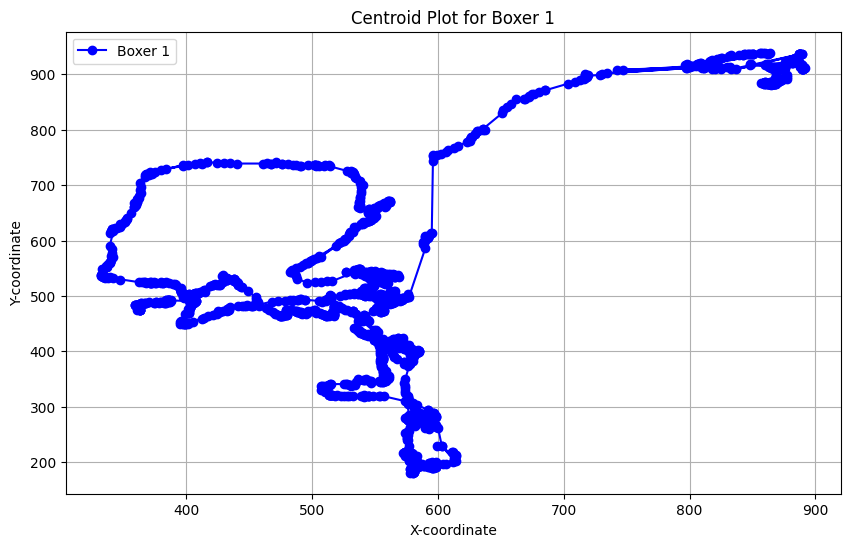

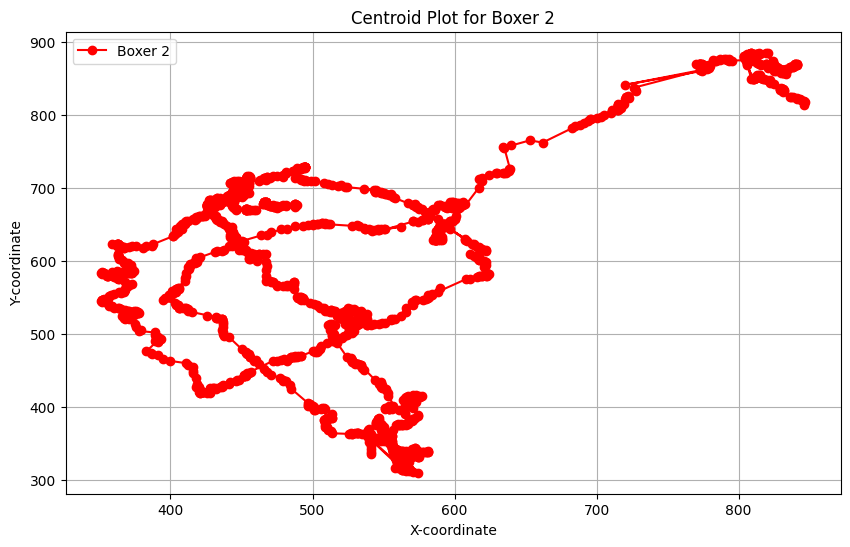

In [3]:
import matplotlib.pyplot as plt
# Load centroids from the saved numpy files
centroids_boxer1 = np.load('centroids1.npy')
centroids_boxer2 = np.load('centroids2.npy')

# Plot centroids for Boxer 1
plt.figure(figsize=(10, 6))
plt.plot(centroids_boxer1[:, 0], centroids_boxer1[:, 1], marker='o', linestyle='-', color='b', label='Boxer 1')
plt.title('Centroid Plot for Boxer 1')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.grid(True)
plt.show()

# Plot centroids for Boxer 2
plt.figure(figsize=(10, 6))
plt.plot(centroids_boxer2[:, 0], centroids_boxer2[:, 1], marker='o', linestyle='-', color='r', label='Boxer 2')
plt.title('Centroid Plot for Boxer 2')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.grid(True)
plt.show()